In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.linalg import eigvals
import random

In [2]:
file_path = '/Users/macbook/Desktop/Research/K-level Network/BeautyContest2018_Dataset.xls'

# Load the Excel file to get the sheet names
xls = pd.ExcelFile(file_path)

# Get the name of the last sheet
last_sheet_name = xls.sheet_names[-2]
print(last_sheet_name)

# Read only the fourth column of the last sheet of the Excel file
df = pd.read_excel(file_path, sheet_name=last_sheet_name, usecols=[3])

# Print the DataFrame to see the content
print(df.head())

Expansión
   v044_choice
0     33.33000
1     33.28000
2     55.00000
3     11.56102
4     35.00000


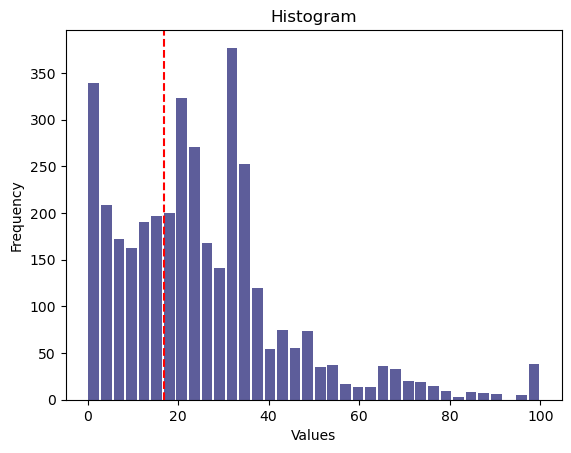

Average Choice: 25.46
Number of Participants: 3,696


In [3]:
last_sheet_name = xls.sheet_names[-2]
df = pd.read_excel(file_path, sheet_name=last_sheet_name, usecols=[3])

# Plotting the histogram
plt.hist(df.iloc[:, 0].dropna(), bins='auto', color='midnightblue', alpha=0.7, rwidth=0.85)  # 'auto' lets matplotlib choose the number of bins
avg_choice = np.mean(df.iloc[:, 0].dropna())
plt.axvline(x=(2/3) * avg_choice, color='red', linestyle='--', label=f'2/3 of Average Choice ({(2/3) * avg_choice:.2f})')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()
print(f'Average Choice: {avg_choice:.2f}')
print(f'Number of Participants: {len(df):,}')

# Our Model 

In [43]:
def belief_function(G, node):
    # Getting the outgoing neighbors (for directed graph)
    neighbors = list(G.successors(node))
    if not neighbors:
        # If no outgoing links, belief is a random number between 0 and node's level - 1
        return random.uniform(0, G.nodes[node]['level'] - 1)
    else:
        # The belief is the average level of the outgoing links
        return np.mean([G.nodes[neighbor]['level'] for neighbor in neighbors])


def choice_function(G, node):
    level = G.nodes[node]['level']
    # Randomly choose between a strategic choice and a completely random choice
    avg_belief = belief_function(G, node)
    # Strategic choice based on the average belief
    if level == 0:
        return random.uniform(1, 100)
    else:
        return ((2/3)**(avg_belief + 1)) * 50

def generate_directed_network(level_counts, p):
    G = nx.DiGraph()
    node_count = 0

    # Add nodes with their levels
    for level, count in enumerate(level_counts):
        for _ in range(count):
            G.add_node(node_count, level=level)
            node_count += 1

    # Connect nodes
    if p == 1:
        # In the case of p=1, connect each node in level k to all nodes in levels 0 to k-1
        for node in G.nodes:
            node_level = G.nodes[node]['level']
            for lower_level_node in G.nodes:
                if G.nodes[lower_level_node]['level'] < node_level:
                    G.add_edge(node, lower_level_node)
    elif p == 0:
        # In the case of p=0, return the graph with no edges
        pass
    else:
        # Calculate modified probability for other cases
        kappa = len(level_counts)
        p_hat = (p * (1 - p)) / (1 - p**(kappa - 1))

        # Connect nodes based on calculated probabilities
        for node in G.nodes:
            node_level = G.nodes[node]['level']
            for target_level in range(kappa):
                if node_level > target_level:
                    prob = (p_hat**(node_level - target_level)) * level_counts[target_level]
                    prob /= sum((p_hat**(node_level - k)) * level_counts[k] for k in range(node_level))
                    for target_node in G.nodes:
                        if G.nodes[target_node]['level'] == target_level and random.random() < prob:
                            G.add_edge(node, target_node)

    return G

def plot_choice_frequency(G):
    # Calculate choices for all nodes
    choices = [choice_function(G, node) for node in G.nodes]

    # Plotting the actual number of players choosing each value
    plt.hist(choices, bins=20, color='midnightblue', alpha=0.7, rwidth=0.85)
    plt.xlabel('Choice Value')
    plt.ylabel('Number of Players')
    plt.title('Number of Players Choosing Each Value')
    plt.xlim(0, 100)

    # Marking the 2/3 of the average of all choices with a dashed line
    avg_choice = np.mean(choices)
    plt.axvline(x=(2/3) * avg_choice, color='red', linestyle='--', label=f'2/3 of Average Choice ({(2/3) * avg_choice:.2f})')
    print(f'2/3 of Average Choice: {(2/3) * avg_choice:.2f}')
    plt.legend()

    plt.savefig('k-level synthetic experiments-Game choices.png', dpi=600)
    plt.show()

[ 488 1006 1006  687  345  117   30   13    3    1]
Total number of nodes: 3,696
2/3 of Average Choice: 17.63


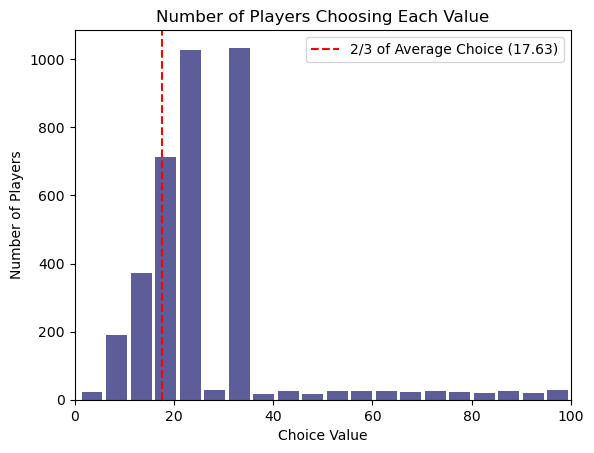

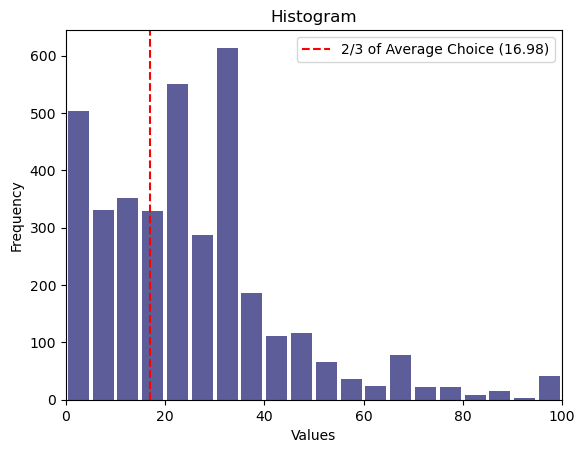

Number of Participants: 3,696


In [46]:
# Parameters
# Define the mean (λ) of the Poisson distribution
lambda_ = 2
# Define the number of levels
num_players = 3696

# Generate the level counts using the Poisson distribution
player_levels = np.random.poisson(lambda_, num_players)
level_counts = np.bincount(player_levels)
print(level_counts)

p = 0.5
network = generate_directed_network(level_counts, p)
choices = [choice_function(network, node) for node in network.nodes]

# total number of nodes 
print(f'Total number of nodes: {network.number_of_nodes():,}')

# Plot the choice frequency for the generated network
plot_choice_frequency(network)

# Plotting the histogram
plt.hist(df.iloc[:, 0].dropna(), bins=20, color='midnightblue', alpha=0.7, rwidth=0.85)  # 'auto' lets matplotlib choose the number of bins
avg_choice = np.mean(df.iloc[:, 0].dropna())
plt.axvline(x=(2/3) * avg_choice, color='red', linestyle='--', label=f'2/3 of Average Choice ({(2/3) * avg_choice:.2f})')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.title('Histogram')
plt.legend()
plt.show()
print(f'Number of Participants: {len(df):,}')

# Level-K Model and Cognitive Hierarchy Model Simulation

In [54]:
from scipy.stats import poisson

# Parameters
num_players = 3696
max_level = len(level_counts)  # Maximum level of reasoning we consider
num_levels = max_level # Number of levels of reasoning
lambda_param = 2  # Mean of the Poisson distribution for player levels
range_min, range_max = 0, 100  # Range of choices

# ----------------------------------------- LEVEL-K MODEL -----------------------------------------
def level_k_sim(num_players, max_level, range_min, range_max):
    # Initialize an array to store each player's choice
    choices = np.zeros(num_players)
    
    
    # Calculate the choices for each level up to the max_level based on the assumption
    # that players of level k best respond to an average of choices by players of level k-1
    level_choices = {0: np.random.uniform(range_min, range_max, num_players)}
    for level in range(1, max_level + 1):
        # Assume all lower level players choose as level k-1 players
        if level - 1 in level_choices:
            assumed_choice = 2/3 * np.mean(level_choices[level - 1])
        else:
            assumed_choice = np.random.uniform(range_min, range_max)  # Fallback for level 0 assumption
        
        # Update the choice for the current level
        level_choices[level] = np.full(num_players, assumed_choice)
    
    # Assign choices to players based on their real level, best responding to the real distribution
    for level in range(max_level + 1):
        # Players at this level best respond to the weighted average of assumed choices up to level-1
        # This is a simplification; in a more detailed model, we'd consider the distribution of levels below each player's level
        player_indices = np.where(player_levels == level)[0]
        if level > 0:
            average_choice = 2/3 * np.mean([np.mean(level_choices[lvl]) for lvl in range(level)])
            choices[player_indices] = average_choice
        else:
            choices[player_indices] = level_choices[0][player_indices]  # Level-0 players choose randomly
    
    return choices
# --------------------------------------------------------------------------------------------


# ----------------------------------------- CH MODEL -----------------------------------------
def compute_aggregate_choice(weights, choices):
    """
    Computes the weighted aggregate choice for players to best respond to.
    weights: Array of weights for each level's choice.
    choices: Dictionary of choices for each level.
    """
    aggregate_choice = sum(weights[level] * np.mean(choices[level]) for level in range(len(weights)))
    return aggregate_choice

def ch_sim(num_players, num_levels, player_levels, level_counts, range_min, range_max):
    # Initialize an array to store choices for each player
    cognitive_hierarchy_choices = np.zeros(num_players)
    
    # Generate Level-0 choices
    level_0_choices = np.random.uniform(range_min, range_max, level_counts[0])
    
    # Dictionary to store choices for each level for reference
    level_choices = {0: level_0_choices}
    
    # Calculate choices for higher levels
    for level in range(1, num_levels):
        if level_counts[level] > 0:  # Proceed only if there are players at this level
            # Compute the weighted average choice of players up to level k-1
            aggregate_choices = np.array([np.mean(level_choices[lvl]) if lvl in level_choices else range_min for lvl in range(level)])
            weighted_choice = 2/3 * np.mean(aggregate_choices)
            
            # Assign this choice to all players at the current level
            level_choices[level] = np.full(level_counts[level], weighted_choice)
    
    # Map the computed choices back to the original players based on their levels
    for player in range(num_players):
        level = player_levels[player]
        level_choice = np.mean(level_choices[level]) if level in level_choices else np.random.uniform(range_min, range_max)
        cognitive_hierarchy_choices[player] = level_choice if level in level_choices else np.random.uniform(range_min, range_max)
    
    return cognitive_hierarchy_choices
# --------------------------------------------------------------------------------------------


level_k_choices = level_k_sim(num_players, max_level, range_min, range_max)
ch_choices = ch_sim(num_players, num_levels, player_levels, level_counts, range_min, range_max)


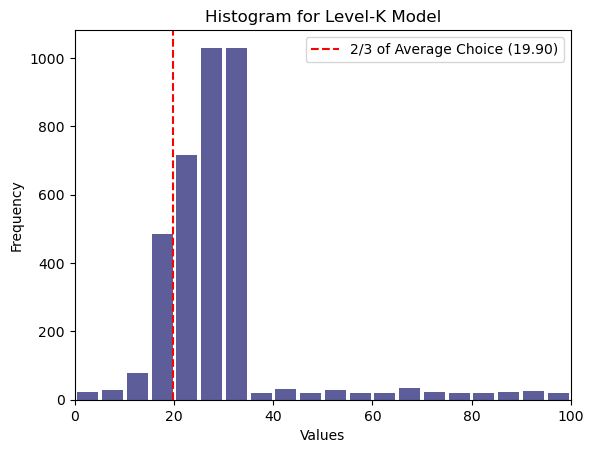

Number of Participants: 3,696


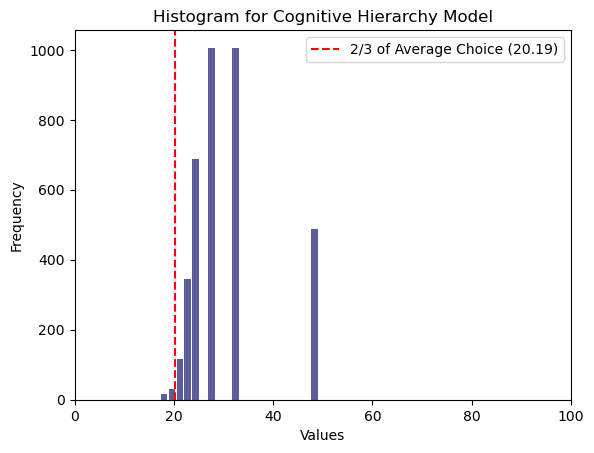

Number of Participants: 3,696


In [56]:
# Compute the actual 2/3 of the average choice for the Level-K Model
avg_choice_level_k = np.mean(level_k_choices)
two_thirds_avg_choice_level_k = 2/3 * avg_choice_level_k

# Compute the actual 2/3 of the average choice for the Cognitive Hierarchy Model
avg_choice_ch = np.mean(ch_choices)
two_thirds_avg_choice_ch = 2/3 * avg_choice_ch

# Plotting the histogram
plt.hist(level_k_choices, bins=20, color='midnightblue', alpha=0.7, rwidth=0.85)  # 'auto' lets matplotlib choose the number of bins
plt.axvline(x=two_thirds_avg_choice_level_k, color='red', linestyle='--', label=f'2/3 of Average Choice ({two_thirds_avg_choice_level_k:.2f})')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.title('Histogram for Level-K Model')
plt.legend()
plt.show()
print(f'Number of Participants: {len(df):,}')

# Plotting the histogram
plt.hist(ch_choices, bins=20, color='midnightblue', alpha=0.7, rwidth=0.85)  # 'auto' lets matplotlib choose the number of bins
plt.axvline(x=two_thirds_avg_choice_ch, color='red', linestyle='--', label=f'2/3 of Average Choice ({two_thirds_avg_choice_ch:.2f})')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.title('Histogram for Cognitive Hierarchy Model')
plt.legend()
plt.show()
print(f'Number of Participants: {len(df):,}')

# Comparisons and performance metrics

In [57]:
import numpy as np
from scipy.stats import norm
from scipy.stats import chisquare
from scipy.stats import wasserstein_distance

def log_likelihood_ratio(choices1, choices2):
    choices1 = np.array(choices1)  # Convert list to numpy array
    choices2 = np.array(choices2)  # Convert list to numpy array
    
    mean1, std1 = np.mean(choices1), np.std(choices1)
    mean2, std2 = np.mean(choices2), np.std(choices2)
    
    ll1 = np.sum(norm.logpdf(choices2, mean1, std1))
    ll2 = np.sum(norm.logpdf(choices2, mean2, std2))
    
    return ll1 - ll2


def chi_squared_goodness_of_fit(choices1, choices2, bins=10):
    choices1 = np.array(choices1)  # Convert list to numpy array
    choices2 = np.array(choices2)  # Convert list to numpy array
    
    # Define the range for binning based on the combined range of both datasets
    combined_range = (min(choices1.min(), choices2.min()), max(choices1.max(), choices2.max()))
    
    counts1, _ = np.histogram(choices1, bins=bins, range=combined_range)
    counts2, _ = np.histogram(choices2, bins=bins, range=combined_range)
    
    chi2_stat, p_value = chisquare(counts1, f_exp=counts2)
    return chi2_stat, p_value


def compute_wasserstein_distance(choices1, choices2):
    choices1 = np.array(choices1)  # Convert list to numpy array
    choices2 = np.array(choices2)  # Convert list to numpy array
    
    return wasserstein_distance(choices1, choices2)


In [58]:
# Calculate the log-likelihood ratio
ll_ratio_k_actual = log_likelihood_ratio(level_k_choices, df.iloc[:, 0].dropna())
ll_ratio_ch_actual = log_likelihood_ratio(ch_choices, df.iloc[:, 0].dropna())
ll_ratio_us_actual = log_likelihood_ratio(choices, df.iloc[:, 0].dropna())

# Calculate the chi-squared statistic and p-value
chi2_stat_k_actual, p_value_k_actual = chi_squared_goodness_of_fit(level_k_choices, df.iloc[:, 0].dropna())
chi2_stat_ch_actual, p_value_ch_actual = chi_squared_goodness_of_fit(ch_choices, df.iloc[:, 0].dropna())
chi2_stat_us_actual, p_value_us_actual = chi_squared_goodness_of_fit(choices, df.iloc[:, 0].dropna())

# Calculate the Wasserstein distance
wass_dist_k_actual = compute_wasserstein_distance(level_k_choices, df.iloc[:, 0].dropna())
wass_dist_ch_actual = compute_wasserstein_distance(ch_choices, df.iloc[:, 0].dropna())
wass_dist_us_actual = compute_wasserstein_distance(choices, df.iloc[:, 0].dropna())

# Output the comparison results
print('Level-K Model:')
print(f'Log-likelihood ratio: {ll_ratio_k_actual:.2f}')
print(f"Level-K Model Chi-Squared Statistic: {chi2_stat_k_actual}, P-value: {p_value_k_actual}")
print(f'Wasserstein distance: {wass_dist_k_actual:.2f}')
print()
print('Cognitive Hierarchy Model:')
print(f'Log-likelihood ratio: {ll_ratio_ch_actual:.2f}')
print(f"CH Model Chi-Squared Statistic: {chi2_stat_ch_actual}, P-value: {p_value_ch_actual}")
print(f'Wasserstein distance: {wass_dist_ch_actual:.2f}')
print()
print('Our Model:')
print(f'Log-likelihood ratio: {ll_ratio_us_actual:.2f}')
print(f"Our Model Chi-Squared Statistic: {chi2_stat_us_actual}, P-value: {p_value_us_actual}")
print(f'Wasserstein distance: {wass_dist_us_actual:.2f}')


# Among ll_ratio_k_actual, ll_ratio_ch_actual, and ll_ratio_us_actual, the model with the highest value is considered to have predictions that best match the distribution of the actual data.
# Lower values of chi2_stat_k_actual, chi2_stat_ch_actual, and chi2_stat_us_actual indicate a better fit, as there's less difference between the observed and expected frequencies. 
# Lower values of wass_dist_k_actual, wass_dist_ch_actual, and wass_dist_us_actual indicate that the model's predictions are closer to the actual data distribution, suggesting a better model fit.

Level-K Model:
Log-likelihood ratio: -668.78
Level-K Model Chi-Squared Statistic: 2033.203182201408, P-value: 0.0
Wasserstein distance: 7.37

Cognitive Hierarchy Model:
Log-likelihood ratio: -5411.47
CH Model Chi-Squared Statistic: 4160.64062576858, P-value: 0.0
Wasserstein distance: 9.38

Our Model:
Log-likelihood ratio: -140.91
Our Model Chi-Squared Statistic: 1036.6131841536258, P-value: 2.191055395319796e-217
Wasserstein distance: 4.38


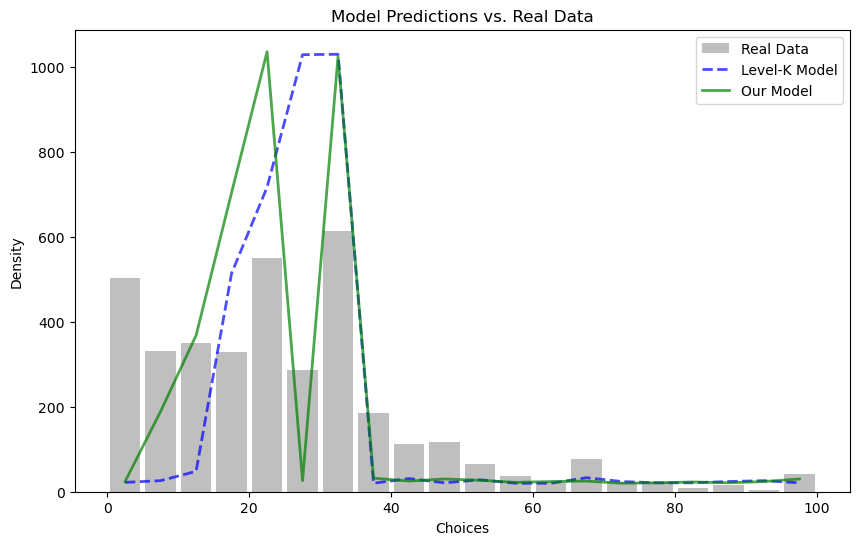

In [107]:
real_data = df.iloc[:, 0].dropna().values  # Convert to numpy array if it's not already

# Define the number of bins for the histogram
bins = 20

# Create the histogram for the real data
hist, bin_edges = np.histogram(real_data, bins=bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Calculate the histogram (as density) for the model predictions
model_k_hist, _ = np.histogram(level_k_choices, bins=bin_edges)
model_ch_hist, _ = np.histogram(ch_choices, bins=bin_edges)
model_us_hist, _ = np.histogram(choices, bins=bin_edges)

# Plotting
plt.figure(figsize=(10, 6))

# Plot the histogram for the real data
plt.hist(real_data, bins=bins, alpha=0.5, label='Real Data', color='gray', rwidth=0.85)

# Plot line plots for the models at the top center of each bin
plt.plot(bin_centers, model_k_hist, label='Level-K Model', linewidth=2, color='blue', linestyle='dashed', alpha=0.7)
# plt.plot(bin_centers, model_ch_hist, label='Cognitive Hierarchy Model', linewidth=2, color='red', linestyle='dotted', alpha=0.7)
plt.plot(bin_centers, model_us_hist, label='Our Model', linewidth=2, color='green', alpha=0.7)

plt.xlabel('Choices')
plt.ylabel('Density')
plt.title('Model Predictions vs. Real Data')
plt.legend()
plt.show()